- leaky relu / elu

## Planet Kaggle competition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fast_gen import *
from learner import *
from pt_models import *
from dataset_pt import *
from sgdr_pt import *

from planet import *

bs=64; f_model = resnet34
path = "/data/jhoward/fast/planet/"
torch.cuda.set_device(1)

In [3]:
n=len(list(open(f'{path}train_v2.csv')))-1

In [4]:
data=get_data_pad(f_model, path, 256, 64, n, 0)

In [5]:
learn = Learner.pretrained_convnet(f_model, data, metrics=[f2])

### Train

In [31]:
learn.fit(0.2, 1, cycle_len=1)

[0.15438985784802958, 0.13450478, 0.87891029153421008]


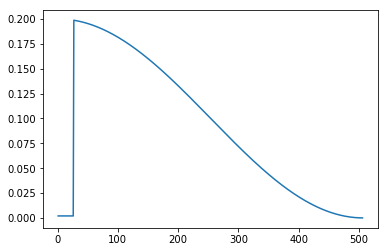

In [32]:
learn.sched.plot_lr()

In [33]:
learn.unfreeze()

In [34]:
learn.fit([0.01,0.05,0.2], 12, cycle_len=4)

[0.11952567681830356, 0.10556465, 0.90650807074212403]


[0.11009075188366914, 0.096736901, 0.91672481730802124]


[0.10827947736338327, 0.093592748, 0.91964642671839225]


[0.1058942063357304, 0.092603102, 0.92130033558366631]


[0.1092922736445057, 0.095529161, 0.91819015894496181]


[0.1011713251614138, 0.092735209, 0.92159361463751932]


[0.09583996319032348, 0.09039887, 0.92251825740384097]


[0.09977698443701977, 0.089664221, 0.92254781482418324]


[0.10362990970969754, 0.092073925, 0.92141614562971053]


[0.10036470544572228, 0.090630345, 0.92154762597476325]


[0.09469915216101382, 0.089381441, 0.92234579315867105]


[0.0912562884700505, 0.089002736, 0.92252729549243617]


In [29]:
learn.fit([1e-4,1e-3,0.01], 4)

[0.09916652571222209, 0.090306021, 0.9227976239444905]


[0.09459107546738892, 0.089821696, 0.92330719115188997]


[0.0965355865038755, 0.089525335, 0.92353226343888395]


[0.09088765592814434, 0.089346372, 0.92387145358147427]


### Evaluate

In [32]:
name = '170809'

In [33]:
def load_cycle_cv(cv, cycle):
    data=get_data_zoom(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    learn.load_cycle(f'{name}_{cv}', cycle)
    return data

In [34]:
data = load_cycle_cv(0,1)

In [35]:
val = learn.predict()

In [36]:
f2(val,data.val_y)

0.92719935814702104

In [37]:
f2(learn.TTA(),data.val_y)

0.92776745163594243

In [27]:
f2(val,data.val_y)

0.93020923622107132

In [59]:
f2(learn.TTA(),data.val_y)

0.93146299154229428

['partly_cloudy', 'primary']


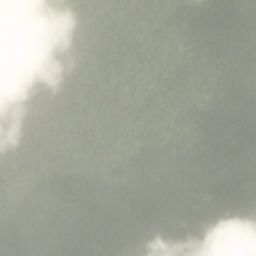

In [38]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

lbls = test>0.2
idx=9
print(get_labels(lbls[idx]))
PIL.Image.open(path+data.test_dl.dataset.fnames[idx]).convert('RGB')

In [39]:
res = [get_labels(o) for o in lbls]
data.test_dl.dataset.fnames[:5]

['test-jpg/test_17555.jpg',
 'test-jpg/test_27899.jpg',
 'test-jpg/test_21010.jpg',
 'test-jpg/test_39610.jpg',
 'test-jpg/test_34768.jpg']

In [40]:
outp = pd.DataFrame({'image_name': [f[9:-4] for f in data.test_dl.dataset.fnames],
        'tags': [' '.join(l) for l in res]})
outp.head()

image_name                                               tags
0  test_17555                agriculture haze primary road water
1  test_27899  agriculture clear partly_cloudy primary road w...
2  test_21010         agriculture bare_ground clear primary road
3  test_39610                     agriculture clear primary road
4  test_34768                     agriculture clear primary road

In [29]:
outp.to_csv('tmp/subm.gz', compression='gzip', index=None)

In [30]:
from IPython.display import FileLink

In [31]:
FileLink('tmp/subm.gz')

/data/jhoward/github/deeplearning/nbs/tmp/subm.gz

In [8]:
def cycle_preds(name, cycle, n_tta=4, is_test=False):
    learn.load_cycle(name, cycle)
    return learn.TTA(n_tta, is_test=is_test)

def cycle_cv_preds(cv, n_tta=4, is_test=False):
    data=get_data_pad(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    return [cycle_preds(f'{name}_{cv}',i, is_test=is_test) for i in range(5)]

- check dogs and cats
- get resize working again with new path structure

In [9]:
%%time
preds_arr=[]
for i in range(5):
    print(i)
    preds_arr.append(cycle_cv_preds(i, is_test=True))

0
1
2
3
4
CPU times: user 6h 23min 45s, sys: 16min 59s, total: 6h 40min 44s
Wall time: 6h 43min 38s


In [41]:
def all_cycle_cv_preds(end_cycle, start_cycle=0, n_tta=4, is_test=False):
    return [cycle_cv_preds(i, is_test=is_test) for i in range(start_cycle, end_cycle)]

In [11]:
np.savez_compressed(f'{path}tmp/test_preds', preds_arr)

In [20]:
preds_avg = [np.mean(o,0) for o in preds_arr]
test = np.mean(preds_avg,0)

In [42]:
%time preds_arr = all_cycle_cv_preds(5)

CPU times: user 54min 11s, sys: 2min 40s, total: 56min 52s
Wall time: 56min 18s


In [55]:
[f2(preds_arr[0][o],data.val_y) for o in range(5)]

[0.93071536605914396,
 0.93116843932677196,
 0.93069579784787815,
 0.9307239826054069,
 0.93051232753450475]

In [44]:
preds_avg = [np.mean(o,0) for o in preds_arr]

In [45]:
ys = [get_data_zoom(f_model, path, 256, 64, n, cv).val_y for cv in range(5)]

In [54]:
f2s = [f2(o,y) for o,y in zip(preds_avg,ys)]; f2s

[0.93137364725177285,
 0.93053278668158479,
 0.93297669347979839,
 0.9323465548921448,
 0.93621843040962094]

In [49]:
ots = [opt_th(o,y) for o,y in zip(preds_avg,ys)]; ots

[0.20000000000000004,
 0.17000000000000001,
 0.21000000000000005,
 0.23000000000000007,
 0.19000000000000003]

In [50]:
np.mean(ots)

0.20000000000000004

In [53]:
np.mean(f2s,0)

0.93268962254298438

### End